Svmは強力で汎用性の高い機械学習モデルで、線形・非線形のクラス分類・回帰・外れ値判定に使うことができます。最もよく知られた機械学習モデルのひとつで、機械学習に興味を持つ人は使えるモデルのひとつに入れておくべきモデルです。svmは特に、小〜中規模の複雑なデータセットに対するクラス分類に威力を発揮します。
この章ではSVMに関して、コアとなる考え方、使い方、どのように動作するかを解説します。

# 5.1 Linear SVM Classification
SVMの基本的な考え方はグラフで説明できます。Figure5-1は4章で導入したアヤメのデータセットを図にしたものです。2つのクラスを直線で分類することができます（このことを線形分離可能といいます）。左図では３つのクラスの決定境界を示してます。実線は明らかに２つのクラス分けることができる直線を示していますが、残りの破線はうまくクラス分類できていません。しかし、うまくクラス分類できている２つの実線についても決定境界がサンプル点に近すぎて、そのサンプル点付近に新たなサンプルが得られた場合、モデルがうまく動作しない可能性があります。一方、右図の実線はSvmの決定境界を表しています。２つのクラスをうまく分類できているだけでなく、近くのサンプル点からなるべく離れた場所に決定境界を引くことができています。このように、SVmはクラスとクラスの間に最も幅が広くなるように道を通す手法であると考えることができます（右図の破線で道を示しています）。このような手法を最大マージン分類といいます。

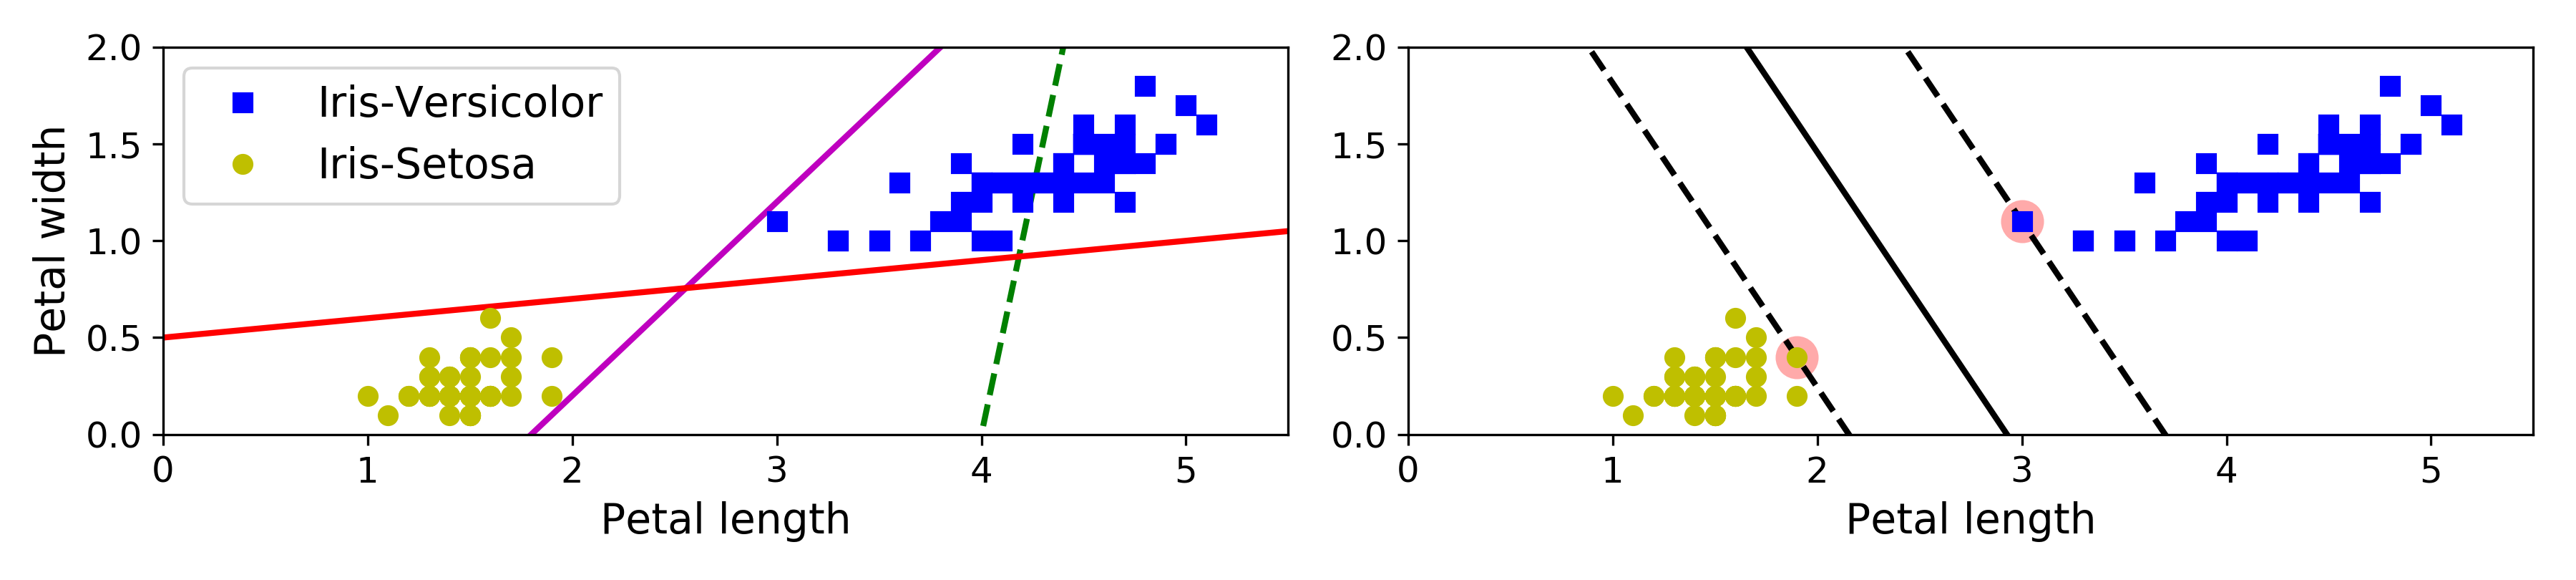

In [7]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh5figure5-1.png"))

道から離れたサンプルを訓練データに追加しても、決定境界にはなんら変化を及ぼさないことに注意してください。道は、それに最も近いサンプル点からのみで、完全に決定されます（support）。この、道に最も近いサンプル点のことをサポートベクタといいます。（figure 5-1の右図で丸をつけたサンプル）

## 5.1.1 Soft Margin Classification
サンプル点が道より外になければならないと言う制約を厳密に従う上記の方法をhard margin classification といいます。hard margin classification には注意すべき点が２つあって、ひとつはデータが線形分離可能でなければならないということ、もうひとつは外れ値に対して非常に影響を受けやすいということです。figure5-3ではirisデータセットに外れ値をひとつ追加したときのグラフです。左図ではhard margin classifier では決定境界を作ることはできなく、右図では外れ値が別のクラスのサンプルに近くなっており、figure5-1の決定境界と比較すると汎化性能が落ちてしまうことは明らかです。

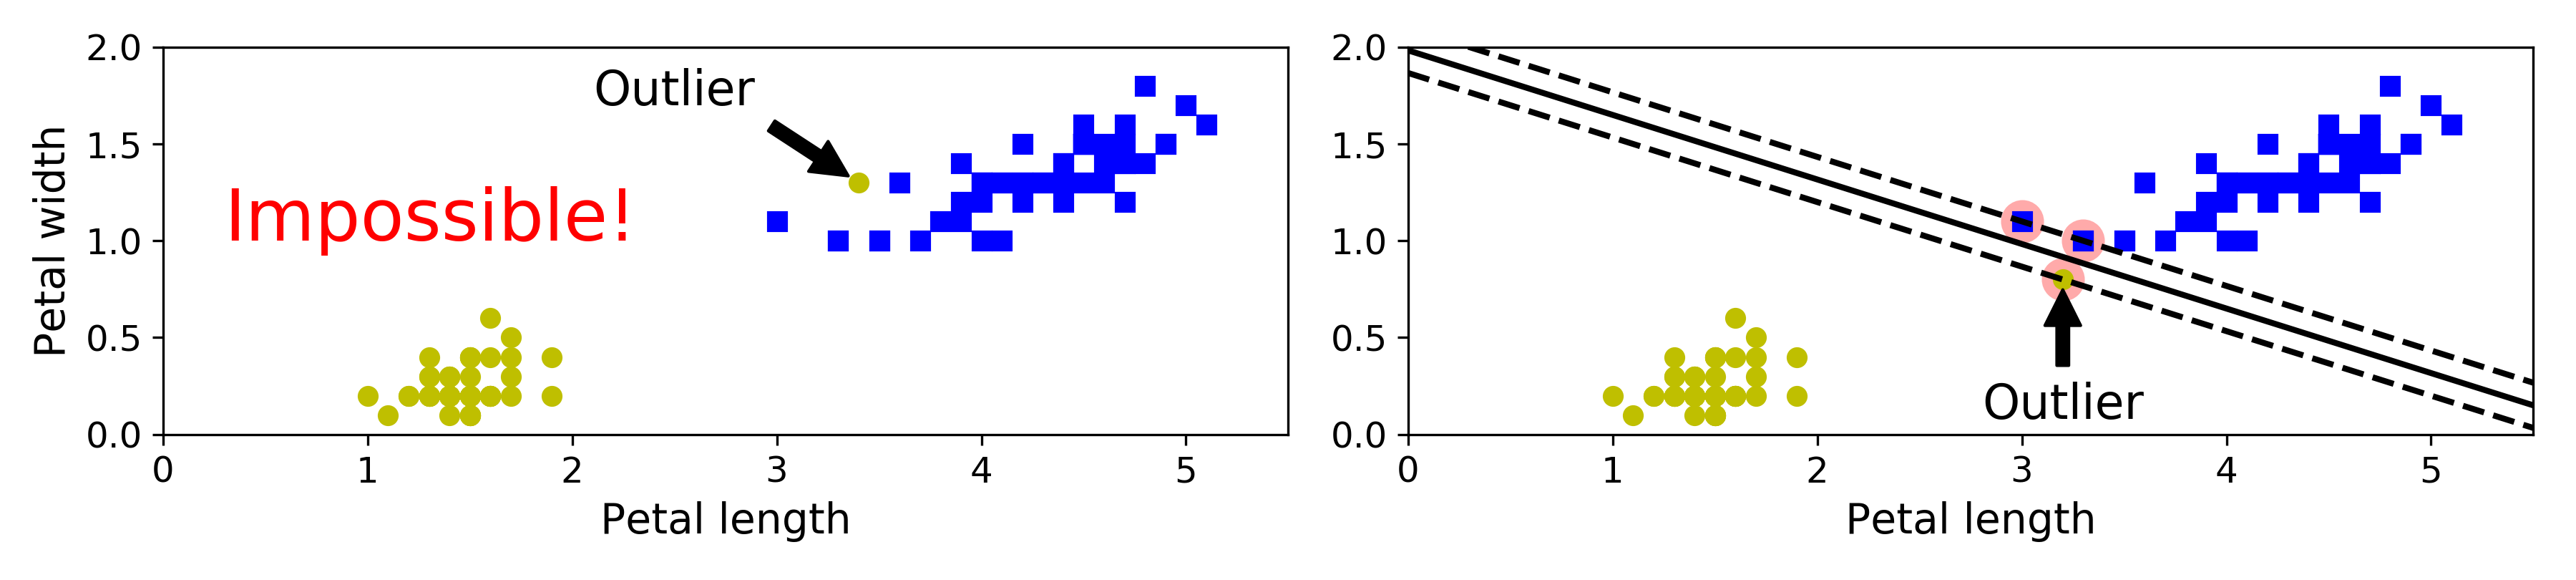

In [8]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh5figure5-3.png"))

より柔軟なモデルを使うことで、これらの注意点を避けることができます。そのモデルの目標はmargin violation(道の逆側にサンプル点が出ること)を抑えつつ、道を広くなる決定境界を決めることです。この方法をsoft margin classification といいます。
Scimitar-learnのSVMクラスではハイパパラメータCでこのバランスを調整することができます。Cが小さければ道幅を広くできる一方、margin violation が多くなります。figure5-4では線形分離不可能なデータに対して、２つのsoft margin classifierの決定境界とmarginを図示しています。左図ではCの値は高くしてあり、margin violation は少ないものの、道幅は狭くなっています。右図ではCの値は低くしてあり、道幅は広いですが、margin violation は多いです。しかし、右図のmargin classifierの方が汎化性能は高そうに見えます。実際、margin violationしているサンプル点も正しいクラスの側にあるものが多く、このデータセットでも予測誤差は小さいものになってます。

次のコードではScikit-learnではirisデータセットをロードし、特徴量を正規化し、LinearSVCクラスをC=1、hinge損失関数で使って当てはめて、Virginica種のアヤメを分類しています。モデルの結果はfigure5-4です

In [ ]:
import numpy as np 
from sklearn import datasets 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC 
iris = datasets . load_iris () 
X = iris [ "data" ][:, ( 2 , 3 )] # petal length, petal width 
y = ( iris [ "target" ] == 2 ) . astype ( np . float64 ) # Iris-Virginica 
svm_clf = Pipeline ([
                               ( "scaler" , StandardScaler ()), 
                               ( "linear_svc" , LinearSVC ( C = 1 , loss = "hinge" )), 
])
svm_clf . fit ( X , y )

In [2]:
svm_clf . predict ([[ 5.5 , 1.7 ]])

array([ 1.])

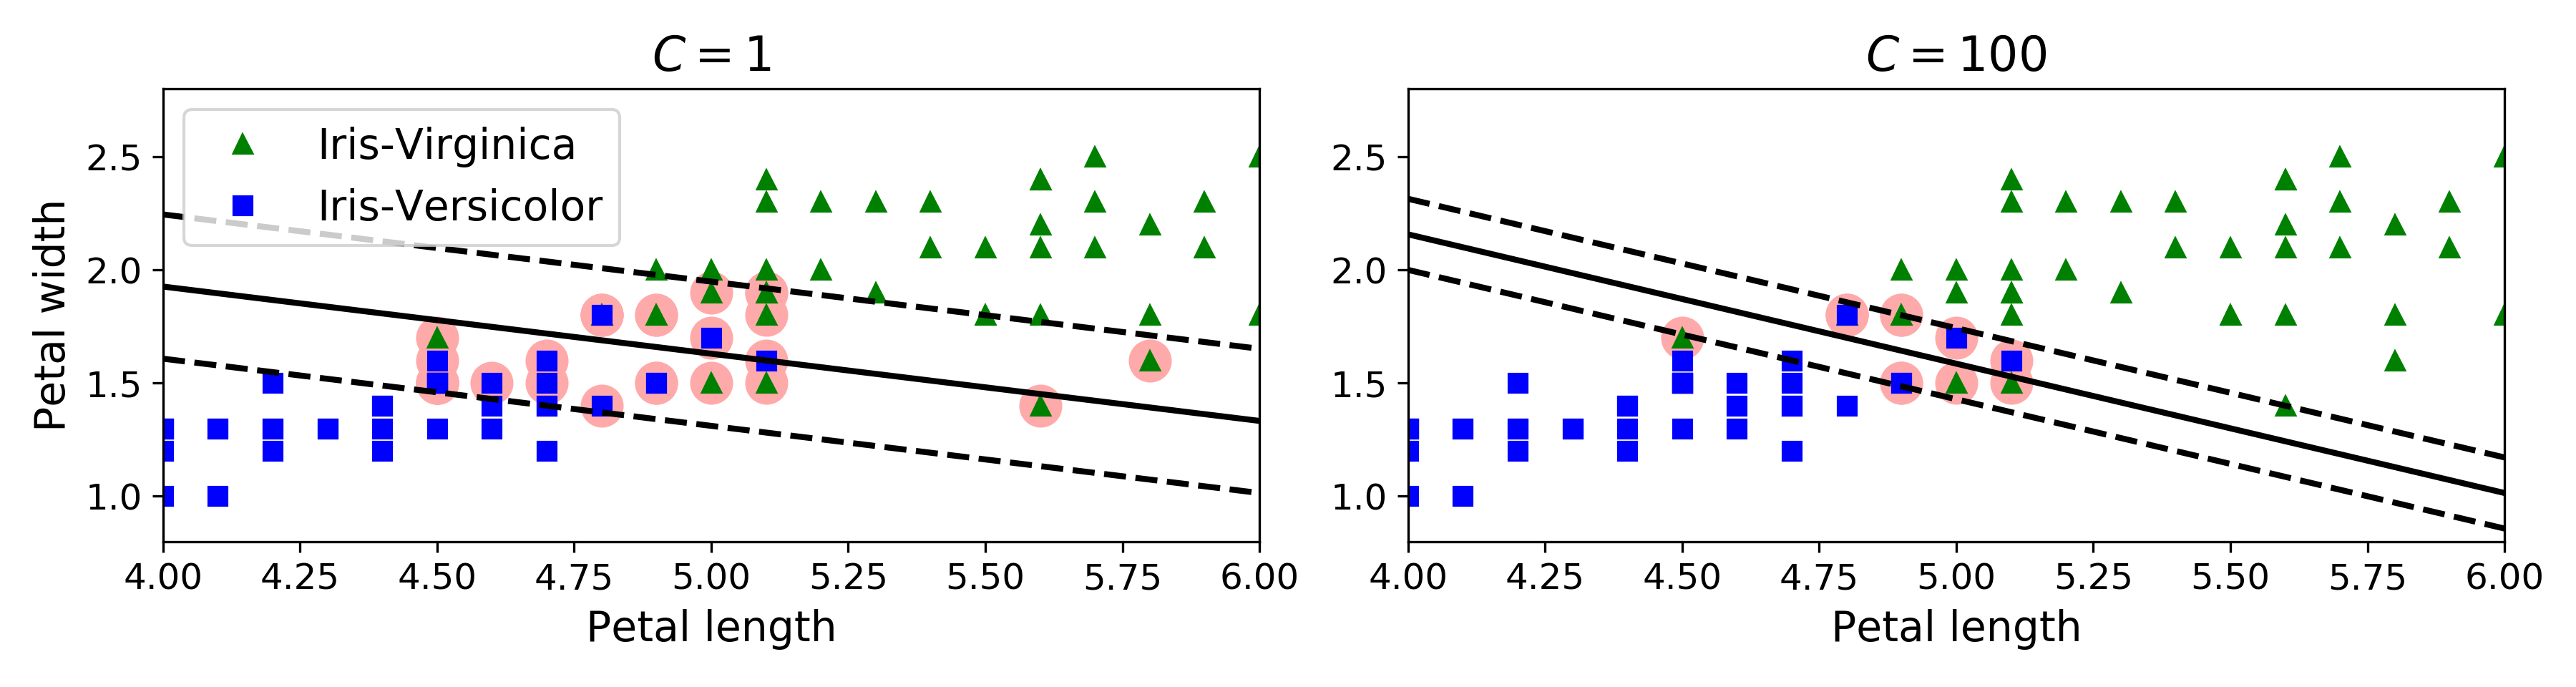

In [9]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh5figure5-4.png"))

上の例の代わりに、kernel=“linear”,C=1としてモデルを当てはめることができますが、大きなデータセットに対しては計算時間がかかるので非推奨です。別の選択肢として、SGDClassifier(loss="hinge", alpha=1/(m*C))とすればSGDClassifierクラスを使うことで、標準的な確率的勾配降下法を用いてlinear SVMで当てはめができます。LinearSVCより収束する速度は遅いですが、大量のデータセットに対してであったり、onlineのクラス分類には便利です。

# 5.2 Nonlinear SVM Classification
多くの場合、linear SVM classifier で効率的かつ効果的にクラス分類できますが、線形分離可能でないデータセットも多いです。非線形なデータセットを扱う方法のひとつに、多項式特徴量などの特徴量を追加して、線形分離可能にする方法があります。figure5-5の左図ではx_1という特徴量ひとつで構成されるデータセットで、丸と三角でクラスが違います。この状態では、線形分離は不可能ですが、ふたつめの特徴量としてx_2=x_1^2を追加すると、その2Dグラフは右図のようになり、線形分離可能になります。

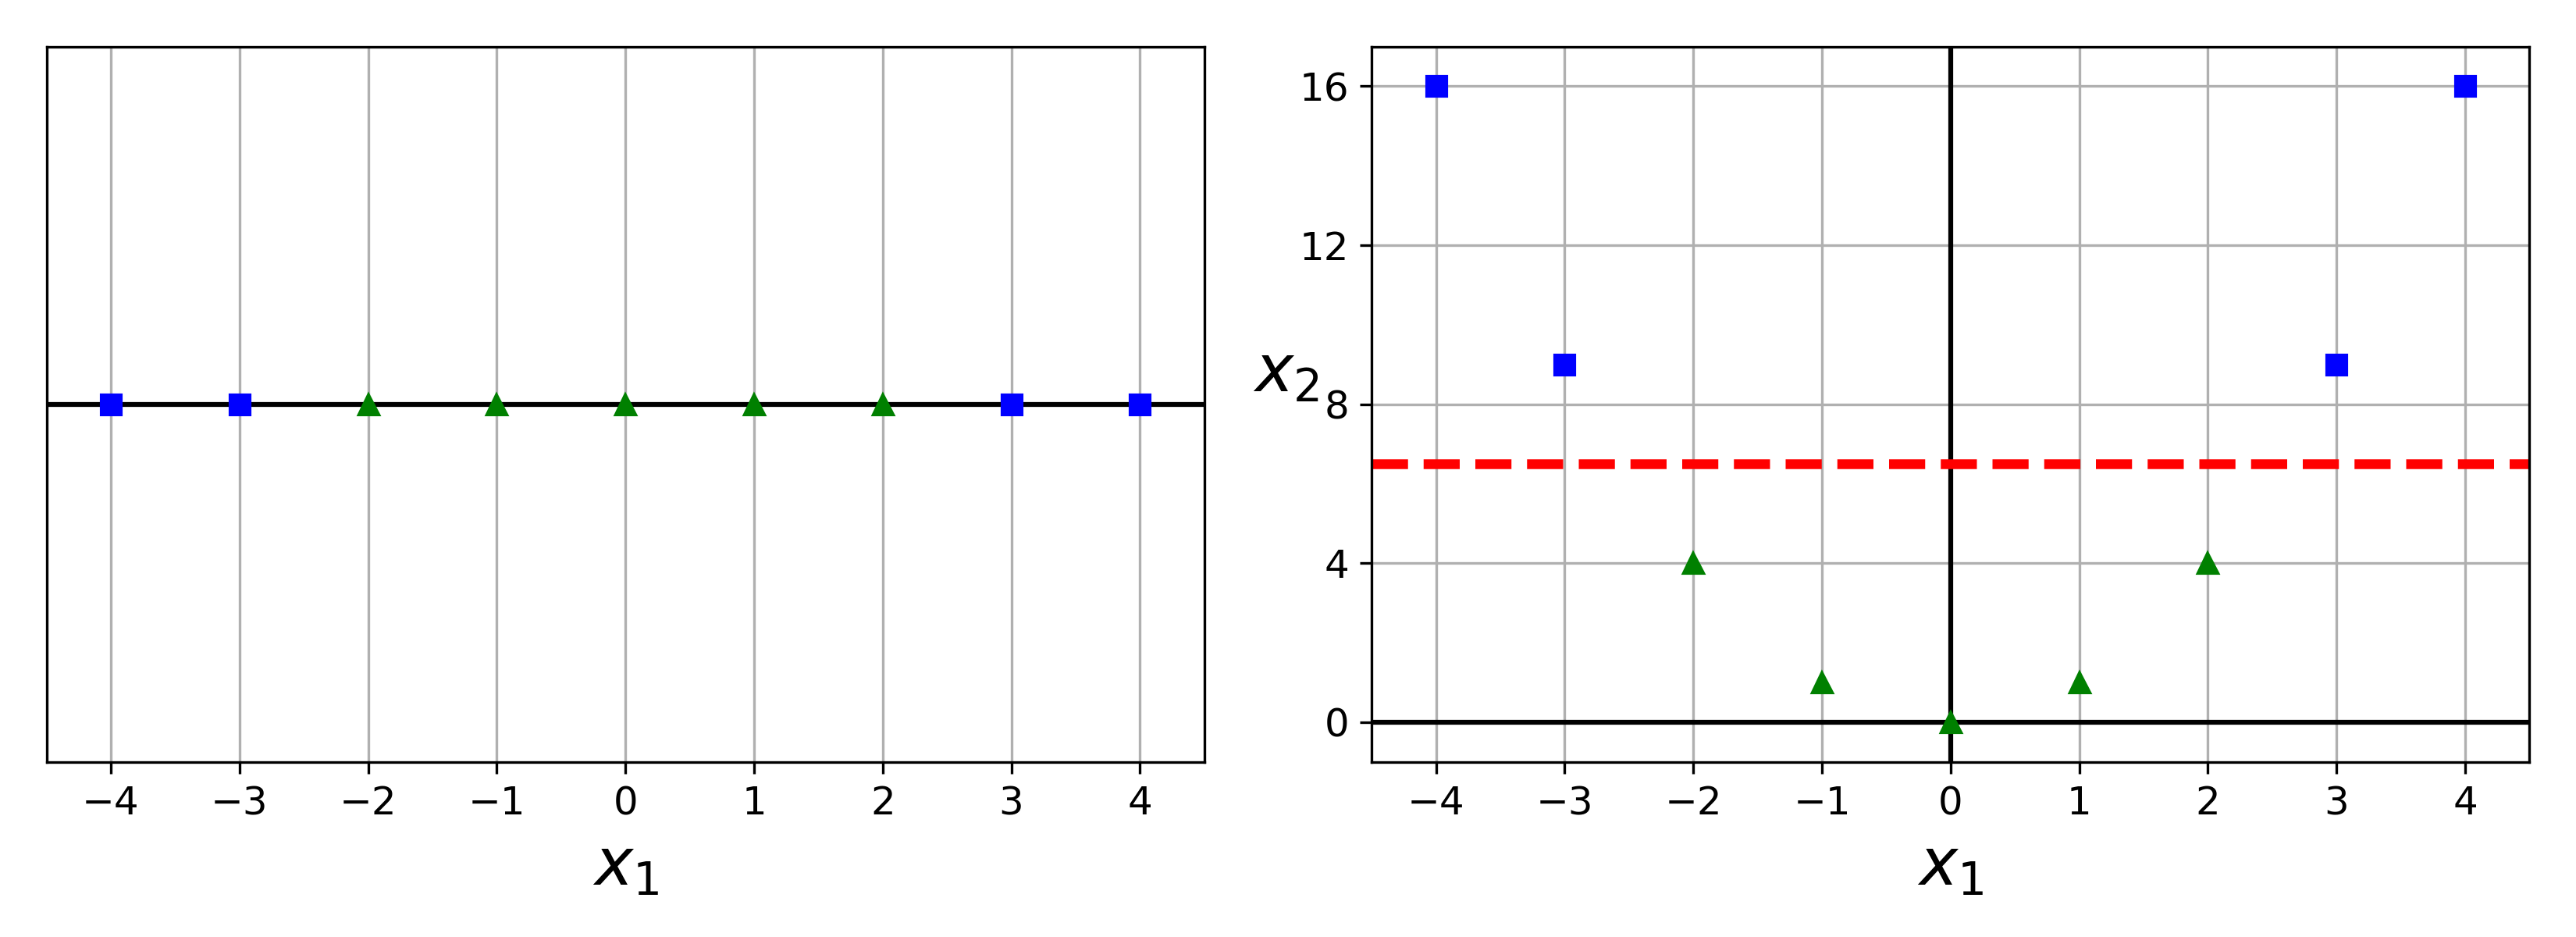

In [10]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh5figure5-5.png"))

PolynomialFeatures変換からStandardScaler 、LinearSVCへ流れるPipelineを作ることで、この考え方をScikit-Learnで実現できます。moonデータセットで試してみましょう。

In [3]:
from sklearn.datasets import make_moons 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import PolynomialFeatures 
polynomial_svm_clf = Pipeline ([
    ( "poly_features" , PolynomialFeatures ( degree = 3 )), 
    ( "scaler" , StandardScaler ()),
    ( "svm_clf" , LinearSVC ( C = 10 , loss = "hinge" )) 
]) 
polynomial_svm_clf . fit ( X , y )

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

結果は次のグラフです．

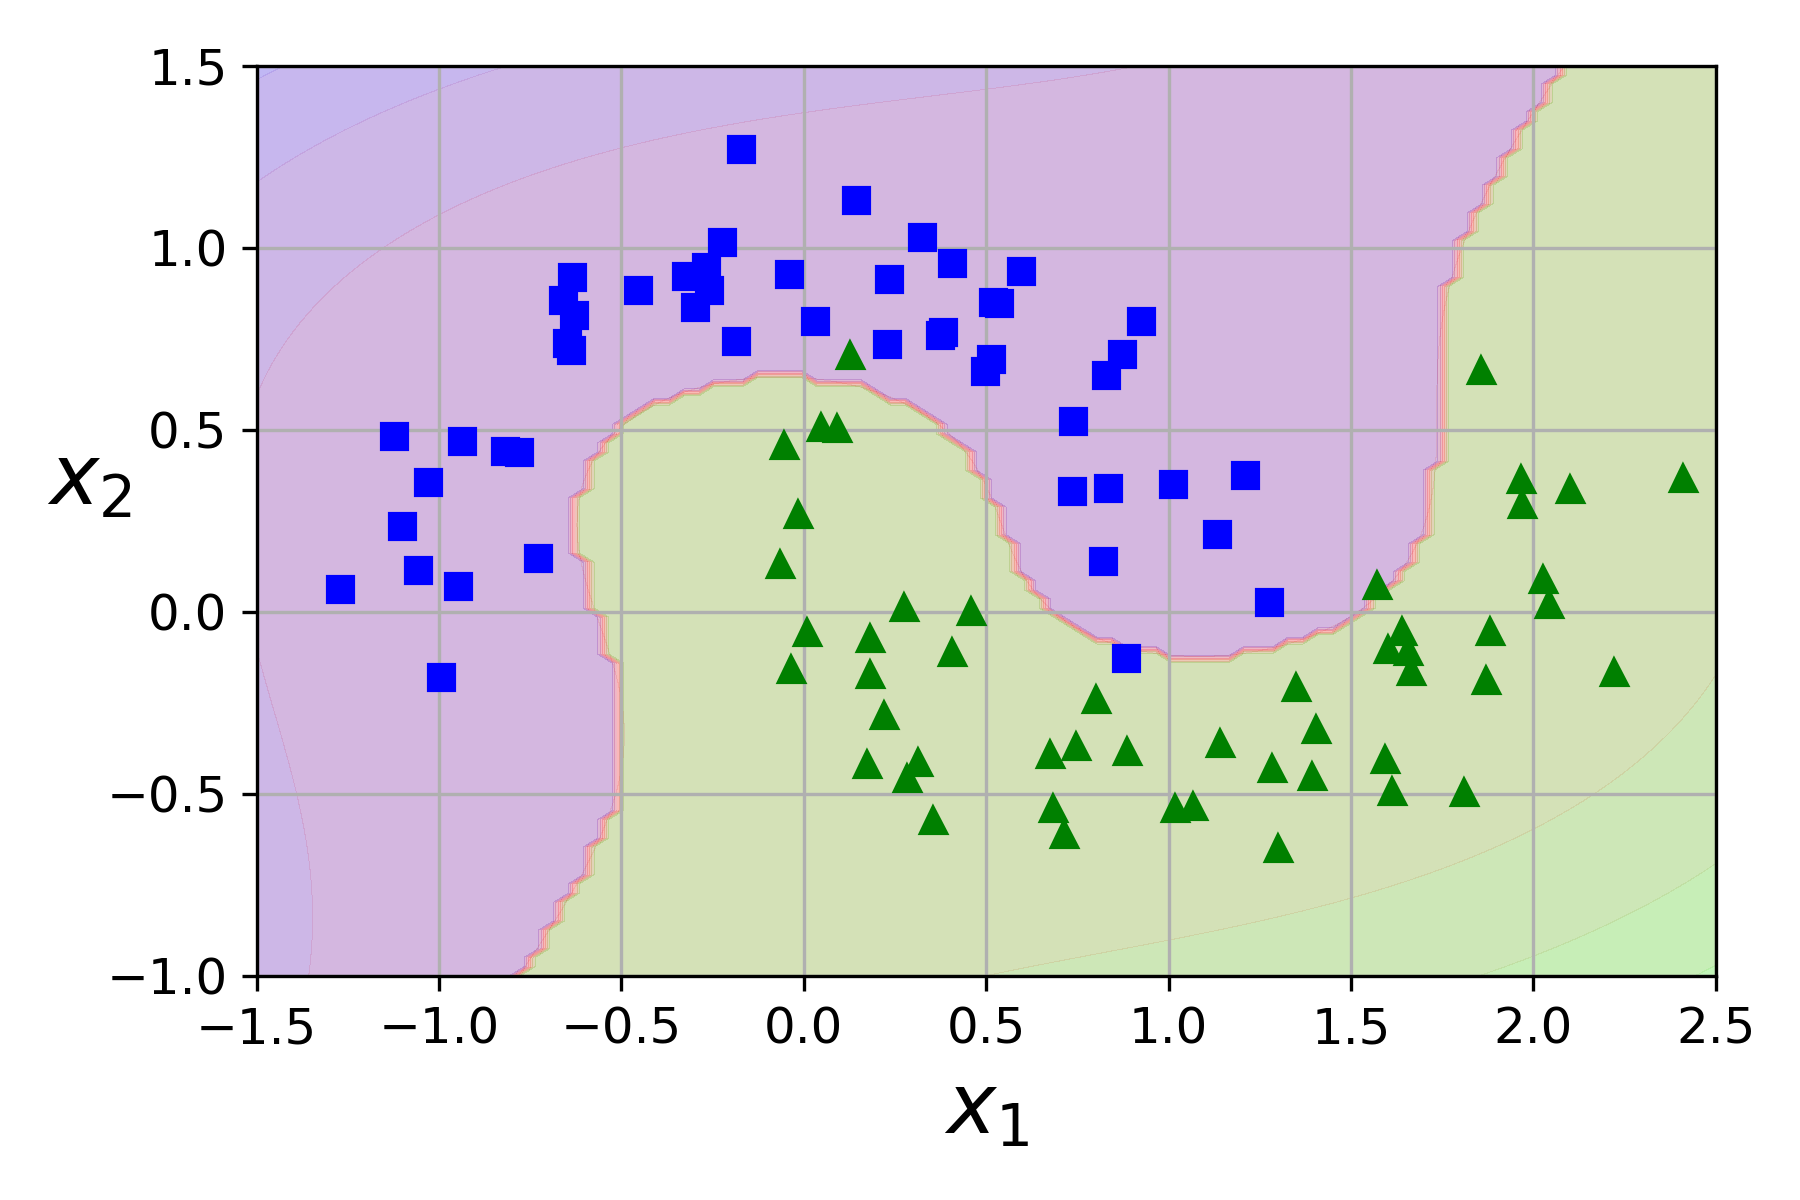

In [1]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh5figure5-6.png"))